In [3]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
#%matplotlib ipympl
import glob as gb
import csv
from time import time
from sklearn import manifold, datasets
from mpl_toolkits.mplot3d import Axes3D

In [20]:
def data_load(data_folders, res, states, file_ext="JPG", exclude=None, include=None):
    
    total = []
    total_f = []
    total_lb = []
    for df in data_folders:
        img_path = gb.glob(df+'/*.'+file_ext ) 
        
        for path in img_path:
            clb = -1
            pl = path.lower()
            
            if exclude is not None and exclude in pl:  
                continue
            
            if include is not None and include not in pl:
                continue
            

            
            for lb in states:
                if lb in pl:
                    clb = states.index(lb)
                    total_lb.append(clb)
                    break
            
            if clb == -1:
                continue
            
            img1 = cv2.imread(path, cv2.IMREAD_GRAYSCALE)#'data/Resized_256_256xBroken_0.JPG', cv2.IMREAD_GRAYSCALE)
            if img1 is None:                   #判断读入的img1是否为空，为空就继续下一轮循环
                continue
            
            res1= cv2.resize(img1,(res,res))              #对图片进行缩放，第一个参数是读入的图片，第二个是制定的缩放大小
            res1 = cv2.equalizeHist(res1)
            
            norm_image = cv2.normalize(res1, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
            
            # Fourier Transform
            f = np.fft.fft2(norm_image)
            fshift = np.fft.fftshift(f)
            fres = 20*np.ma.log(np.abs(fshift))
            fres2 = fres.flatten().tolist()   
            
            res1_1 = norm_image.flatten()#res1_1 = res1.reshape(1,784)/255.0       #将表示图片的二维矩阵转换成一维
            #im_data = np.concatenate((im_data, res1_1))
            res1_1_1 = res1_1.tolist()                     #将numpy.narray类型的矩阵转换成list
            total.append(res1_1_1)  
            total_f.append(fres2)
            
    im_data = np.array(total).astype('int32')
    #im_data.astype('int32')
    
    im_dataf = np.array(total_f).astype('float32')
    #im_dataf.astype('float32')
    
    im_lb = np.array(total_lb).astype('int32')
    #im_lb.astype('int32')
    
    #print(im_dataf.dtype)
    im_dataf[np.isnan(im_dataf)] = np.nanmean(im_dataf)
    im_dataf[np.isinf(im_dataf)] = np.nanmean(im_dataf)

    return im_data, im_dataf, im_lb


In [21]:
# Preprocess IMG Data
fd = ['data']
res = 64
im_data, im_dataf, im_lb = data_load(fd, res, ['dripping', 'jetting', 'wetting', 'broken'], include = '30oct17')

In [23]:
im_data.tofile('data/img'+str(res)+'.bin')
im_dataf.tofile('data/imgf'+str(res)+'.bin')
im_lb.tofile('data/label.bin')

In [4]:
# Load Data
res = 64
res2 = res*res
data = np.fromfile('data/img'+str(res)+'.bin',  dtype=np.float32)
im_data = data.reshape(-1, res2)

data2 = np.fromfile('data/imgf'+str(res)+'.bin',  dtype=np.float32)
im_dataf = data2.reshape(-1, res2)

# Load Label
im_lb = np.fromfile('data/label.bin', dtype=np.int32)


In [ ]:
#digits = datasets.load_digits(n_class=5)
X = im_data#digits.data
y = im_lb#digits.target

tsne = manifold.TSNE(n_components=3, init='pca', random_state=0)
t0 = time()
X_tsne = tsne.fit_transform(X)
#plot_embedding_2d(X_tsne[:,0:2],"t-SNE 2D")


In [16]:
def plot_embedding_3d(X, title=None, colornum = 10):
    #坐标缩放到[0,1]区间
    x_min, x_max = np.min(X,axis=0), np.max(X,axis=0)
    X = (X - x_min) / (x_max - x_min)
    #降维后的坐标为（X[i, 0], X[i, 1],X[i,2]），在该位置画出对应的digits
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    for i in range(X.shape[0]):
        ax.text(X[i, 0], X[i, 1], X[i,2],str(digits.target[i]),
                 color=plt.cm.Set1(y[i] / colornum),
                 fontdict={'weight': 'bold', 'size': 9})
    if title is not None:
        plt.title(title)

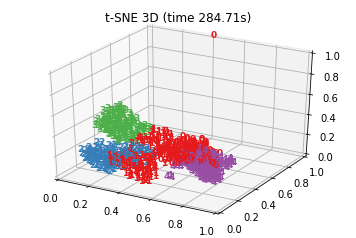

In [40]:
plot_embedding_3d(X_tsne,"t-SNE 3D (time %.2fs)" %(time() - t0))

In [48]:
import numpy as np
import sklearn
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits

# Random state.
RS = 20150101

import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib

# We import seaborn to make nice plots.
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
digits = load_digits()
# We first reorder the data points according to the handwritten numbers.
#X = np.vstack([digits.data[digits.target==i]
#               for i in range(10)])
#y = np.hstack([digits.target[digits.target==i]
#               for i in range(10)])

X = im_dataf[0:1000,:]
y = im_lb[0:1000]

digits_proj = TSNE(random_state=RS).fit_transform(X)

def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

scatter(digits_proj, y)
plt.savefig('digits_tsne-generated.png', dpi=120)
plt.show()

E:\Anaconda\envs\DSSI\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
E:\Anaconda\envs\DSSI\lib\site-packages\numpy\core\_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


RuntimeError: libpng signaled error

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
pcs = pca.fit_transform(im_data)
pcsf = pca.fit_transform(im_dataf)


In [17]:

#digits = datasets.load_digits(n_class=5)
X = pcsf
y = im_lb

tsne = manifold.TSNE(n_components=3, init='pca', random_state=0)
t0 = time()
X_tsne = tsne.fit_transform(X)


E:\Anaconda\envs\DSSI\lib\site-packages\sklearn\decomposition\pca.py:505: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()


In [18]:
def plot_embedding_3d(X, title=None, y=None, colornum=10, colors = ['r', 'g', 'b', 'y']):
    #坐标缩放到[0,1]区间
    x_min, x_max = np.min(X,axis=0), np.max(X,axis=0)
    X = (X - x_min) / (x_max - x_min)
    #降维后的坐标为（X[i, 0], X[i, 1],X[i,2]），在该位置画出对应的digits
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    for i in range(X.shape[0]):
        ax.text(X[i, 0], X[i, 1], X[i,2],str(y[i]),
                 color=colors[y[i]],#plt.cm.Set1(y[i] / colornum),
                 fontdict={'weight': 'bold', 'size': 9})
    if title is not None:
        plt.title(title)

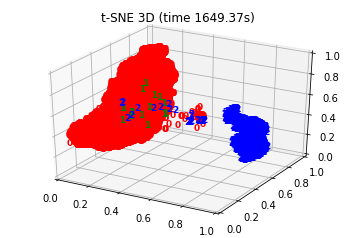

In [20]:
plot_embedding_3d(X_tsne,"t-SNE 3D (time %.2fs)" %(time() - t0), y=im_lb, colornum=4)

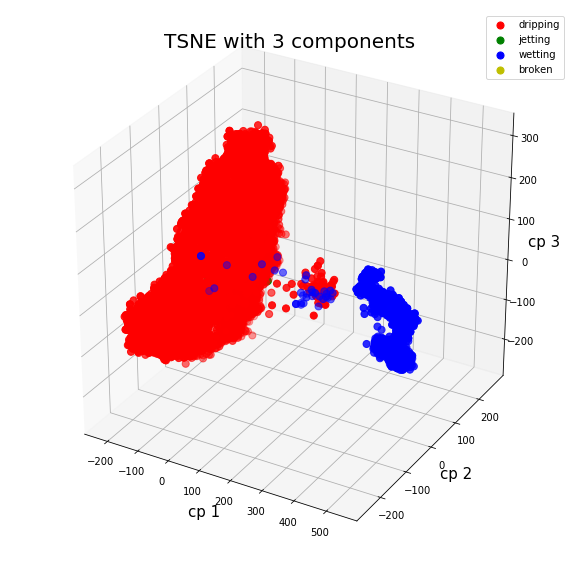

In [26]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('cp 1', fontsize = 15)
ax.set_ylabel('cp 2', fontsize = 15)
ax.set_zlabel('cp 3', fontsize = 15)
ax.set_title('TSNE with 3 components', fontsize = 20)
targets = [0,1,2,3]
states = ['dripping', 'jetting', 'wetting', 'broken']
colors = ['r', 'g', 'b', 'y']
for target, color, state in zip(targets,colors,states):
    ##indicesToKeep = finalDf['target'] == target
    ind = im_lb == target
    ax.scatter(pcsf[ind,0],#finalDf.loc[indicesToKeep, 'principal component 1']
               pcsf[ind,1],#, finalDf.loc[indicesToKeep, 'principal component 2']
               pcsf[ind,2],
               c = color,
               s = 50)
ax.legend(states)
ax.grid()

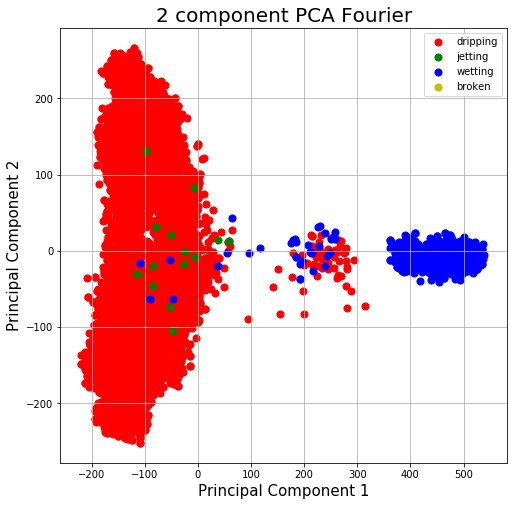

In [24]:
from sklearn.decomposition import PCA
#pca = PCA(n_components=2)
#principalComponents = pca.fit_transform(im_dataf)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA Fourier', fontsize = 20)
targets = [0,1,2,3]
states = ['dripping', 'jetting', 'wetting', 'broken']
colors = ['r', 'g', 'b', 'y']
for target, color, state in zip(targets,colors,states):
    ##indicesToKeep = finalDf['target'] == target
    ind = im_lb == target
    ax.scatter(pcsf[ind,0],#finalDf.loc[indicesToKeep, 'principal component 1']
               pcsf[ind,1],#, finalDf.loc[indicesToKeep, 'principal component 2']
               c = color,
               s = 50)
ax.legend(states)
ax.grid()